In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

#import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



from pyvirchow.normalization import MacenkoNormalization
from pyvirchow.normalization import ReinhardNormalization
from pyvirchow.normalization import VahadaneNormalization
from pyvirchow.normalization import XuNormalization

import scipy as sp

from pyvirchow.io import WSIReader
from pyvirchow.io.operations import read_as_rgb
import numpy.linalg as LA
from skimage.filters import try_all_threshold

from sklearn.decomposition import NMF
from sklearn.decomposition import nmf
from sklearn.linear_model import Lasso

from skimage.io import imshow
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from skimage.filters import threshold_otsu

from pyvirchow.morphology.operations import open_close, close_open, imerode, imdilate, imopening, imclosing
from pyvirchow.normalization.color_conversion import normalize_brightness
from pyvirchow.segmentation import poisson_deconvolve
from pyvirchow.segmentation import perform_binary_cut

from numpy import linalg as LA
from skimage.color import rgb2gray, gray2rgb
import spams
from scipy import ndimage as ndi

from skimage.feature import canny


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


Populating the interactive namespace from numpy and matplotlib


In [2]:
np.finfo('float').eps

2.220446049250313e-16

In [3]:
x = np.array([(1,2), (2,3)])
x

array([[1, 2],
       [2, 3]])

# shapely check

In [105]:
import math

import numpy as np

from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize


def cdog(im_input, im_mask, sigma_min, sigma_max, num_octave_levels=3):
    """SCale-adaptive Multiscale Difference-of-Gaussian (DoG) filter for
    nuclei/blob detection.
    Computes the maximal DoG response over a series of scales where in the
    applicable scales at each pixel are constrained to be below an upper-bound
    equal to 2 times the distance to the nearest non-nuclear/background pixel.
    This function uses an approach similar to SIFT interest detection
    where in the scale space between the specified min and max sigma values is
    divided into octaves (scale/sigma is doubled after each octave) and each
    octave is divided into sub-levels. The gaussian images are downsampled by 2
    at the end of each octave to keep the size of convolutional filters small.
    Parameters
    ----------
    im_input : array_like
        A hematoxylin intensity image obtained from ColorDeconvolution. Objects
        are assumed to be dark with a light background.
    mask : array_like
        A binary image where nuclei pixels have non-zero values
    sigma_min : double
        Minumum sigma value for the scale space. For blob detection, set this
        equal to minimum-blob-radius / sqrt(2).
    sigma_max : double
        Maximum sigma value for the scale space. For blob detection, set this
        equal to maximum-blob-radius / sqrt(2).
    num_octave_levels : int
        Number of levels per octave in the scale space.
    Returns
    -------
    im_dog_max : array_like
        An intensity image containing the maximal DoG response accross
        all scales for each pixel
    im_sigma_max : array_like
        An intensity image containing the sigma value corresponding to the
        maximal LoG response at each pixel. The nuclei/blob radius for
        a given sigma value can be calculated as sigma * sqrt(2).
    References
    ----------
    .. [*] D.G. Lowe "Distinctive image features from scale-invariant
           keypoints." International journal of computer vision, vol. 60,
           no. 2, 91-110, 2004.
    """

    im_input = im_input.astype(np.float)

    # generate distance map
    im_dmap = distance_transform_edt(im_mask)

    # compute max sigma at each pixel as 2 times the distance to background
    im_sigma_ubound = 2.0 * im_dmap

    # clip max sigma values to specified range
    im_sigma_ubound = np.clip(im_sigma_ubound, sigma_min, sigma_max)

    # compute number of levels in the scale space
    sigma_ratio = 2 ** (1.0 / num_octave_levels)

    k = int(math.log(float(sigma_max) / sigma_min, sigma_ratio)) + 1

    # Compute maximal DoG filter response accross the scale space
    sigma_cur = sigma_min
    im_gauss_cur = gaussian_filter(im_input, sigma_cur)
    im_sigma_ubound_cur = im_sigma_ubound.copy()

    MIN_FLOAT = np.finfo(im_input.dtype).min

    im_dog_max = np.zeros_like(im_input)
    im_dog_max[:, :] = MIN_FLOAT
    im_dog_octave_max = im_dog_max.copy()

    im_sigma_max = np.zeros_like(im_input)
    im_sigma_octave_max = np.zeros_like(im_input)

    n_level = 0
    n_octave = 0

    for i in range(k + 1):

        # calculate sigma at next level
        sigma_next = sigma_cur * sigma_ratio

        # Do cascaded convolution to keep convolutional kernel small
        # G(a) * G(b) = G(sqrt(a^2 + b^2))
        sigma_conv = np.sqrt(sigma_next ** 2 - sigma_cur ** 2)
        sigma_conv /= 2.0 ** n_octave

        im_gauss_next = gaussian_filter(im_gauss_cur, sigma_conv)

        # compute DoG
        im_dog_cur = im_gauss_next - im_gauss_cur

        # constrain response
        im_dog_cur[im_sigma_ubound_cur < sigma_cur] = MIN_FLOAT

        # update maxima
        max_update_pixels = np.where(im_dog_cur > im_dog_octave_max)
        print(max_update_pixels)
        if len(max_update_pixels[0]) > 0:

            im_dog_octave_max[max_update_pixels] = im_dog_cur[max_update_pixels]
            im_sigma_octave_max[max_update_pixels] = sigma_cur

            # print np.unique(im_sigma_octave_max)

        # update cur sigma
        sigma_cur = sigma_next
        im_gauss_cur = im_gauss_next

        # udpate level
        n_level += 1

        # Do additional processing at the end of each octave
        if i == k or n_level == num_octave_levels:

            # update maxima
            if num_octave_levels > 0:

                im_dog_octave_max_rszd = resize(
                    im_dog_octave_max, im_dog_max.shape, order=0)

            else:

                im_dog_octave_max_rszd = im_dog_octave_max

            max_pixels = np.where(
                im_dog_octave_max_rszd > im_dog_max)

            if len(max_pixels[0]) > 0:

                im_dog_max[max_pixels] = \
                    im_dog_octave_max_rszd[max_pixels]

                if num_octave_levels > 0:

                    im_sigma_octave_max_rszd = resize(
                        im_sigma_octave_max, im_dog_max.shape, order=0)

                else:

                    im_sigma_octave_max_rszd = im_sigma_octave_max

                im_sigma_max[max_pixels] = \
                    im_sigma_octave_max_rszd[max_pixels]

            # downsample images by 2 at the end of each octave
            if n_level == num_octave_levels:

                im_gauss_cur = im_gauss_next[::2, ::2]
                im_sigma_ubound_cur = im_sigma_ubound_cur[::2, ::2]

                im_dog_octave_max = im_dog_octave_max[::2, ::2]
                im_sigma_octave_max = im_sigma_octave_max[::2, ::2]

                n_level = 0
                n_octave += 1

    # set min vals to min response
    im_dog_max[im_dog_max == MIN_FLOAT] = 0

    return im_dog_max, im_sigma_max

In [13]:
import pyximport
pyximport.install(reload_support=True)
import _max_clustering_cython

In [14]:
import numpy as np
import skimage.measure

from _max_clustering_cython import _max_clustering_cython


def max_clustering(im_response, im_fgnd_mask, r=10):
    """Local max clustering pixel aggregation for nuclear segmentation.
    Takes as input a constrained log or other filtered nuclear image, a binary
    nuclear mask, and a clustering radius. For each pixel in the nuclear mask,
    the local max is identified. A hierarchy of local maxima is defined, and
    the root nodes used to define the label image.
    Parameters
    ----------
    im_response : array_like
        A filtered-smoothed image where the maxima correspond to nuclear
        center. Typically obtained by constrained-LoG filtering on a
        hematoxylin intensity image obtained from ColorDeconvolution.
    im_fgnd_mask : array_like
        A binary mask of type boolean where nuclei pixels have value
        'True', and non-nuclear pixels have value 'False'.
    r : float
        A scalar defining the clustering radius. Default value = 10.
    Returns
    -------
    im_label : array_like
        im_label image where positive values correspond to foreground pixels that
        share mutual sinks.
    seeds : array_like
        An N x 2 array defining the (x,y) coordinates of nuclei seeds.
    max_response : array_like
        An N x 1 array containing the maximum response value corresponding to
        'seeds'.
    See Also
    --------
    histomicstk.filters.shape.clog
    References
    ----------
    .. [#] XW. Wu et al "The local maximum clustering method and its
       application in microarray gene expression data analysis,"
       EURASIP J. Appl. Signal Processing, volume 2004, no.1, pp.53-63,
       2004.
    .. [#] Y. Al-Kofahi et al "Improved Automatic Detection and Segmentation
       of Cell Nuclei in Histopathology Images" in IEEE Transactions on
       Biomedical Engineering,vol.57,no.4,pp.847-52, 2010.
    """

    # find local maxima of all foreground pixels
    mval, mind = _max_clustering_cython(
        im_response, im_fgnd_mask.astype(np.int32), r
    )

    # identify connected regions of local maxima and define their seeds
    im_label = skimage.measure.label(im_fgnd_mask & (im_response == mval))

    # compute normalized response
    min_resp = im_response.min()
    max_resp = im_response.max()
    resp_range = max_resp - min_resp

    im_response_nmzd = (im_response - min_resp) / resp_range

    # compute object properties
    obj_props = skimage.measure.regionprops(im_label, im_response_nmzd)

    obj_props = [prop for prop in obj_props if np.isfinite(prop.weighted_centroid).all()]

    num_labels = len(obj_props)

    # extract object seeds
    seeds = np.array(
        [obj_props[i].weighted_centroid for i in range(num_labels)])
    seeds = np.round(seeds).astype(np.int)

    # fix seeds outside the object region - happens for non-convex objects
    for i in range(num_labels):

        sy = seeds[i, 0]
        sx = seeds[i, 1]

        if im_label[sy, sx] == obj_props[i].label:
            continue

        # find object point with closest manhattan distance to center of mass
        pts = obj_props[i].coords

        ydist = np.abs(pts[:, 0] - sy)
        xdist = np.abs(pts[:, 1] - sx)

        seeds[i, :] = pts[np.argmin(xdist + ydist), :]

        assert im_label[seeds[i, 0], seeds[i, 1]] == obj_props[i].label

    # get seed responses
    max_response = im_response[seeds[:, 0], seeds[:, 1]]

    # set label of each foreground pixel to the label of its nearest peak
    im_label_flat = im_label.ravel()

    pind = np.flatnonzero(im_fgnd_mask)

    mind_flat = mind.ravel()

    im_label_flat[pind] = im_label_flat[mind_flat[pind]]

    # return
    return im_label, seeds, max_response

In [15]:
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_100.tif'
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_004.tif'

tumor_wsi = WSIReader(tumor, 40)
normal_wsi = WSIReader(normal, 40)

In [16]:
x0 = int(59792/2)#30000
y0 = int(233184/2)
tumor_rgb = tumor_wsi.get_patch_by_level(x0, y0, level=0, patch_size=128)

x0 = int(97792/2)
y0 = int(212992/1.5)
normal_rgb = normal_wsi.get_patch_by_level(x0, y0, level=0, patch_size=128)

Text(0.5,1,'Normal')

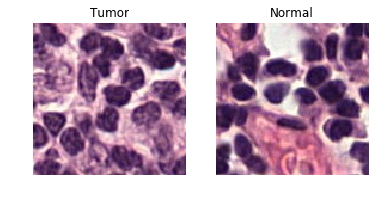

In [17]:
fig = plt.figure()
ax = plt.subplot(121)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(122)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')


# Normalization

In [18]:
macenko_fit = {}
H_channel_m = {}
E_channel_m = {}

macenko_fit['tumor'] = MacenkoNormalization()
macenko_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

macenko_fit['normal'] = MacenkoNormalization()
macenko_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))

H_channel_m['tumor'] = macenko_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_m['tumor'] = macenko_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_m['normal'] = macenko_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_m['normal'] = macenko_fit['normal'].get_eosin_channel(normal_rgb)

In [19]:
vahadane_fit = {}
H_channel_v = {}
E_channel_v = {}

vahadane_fit['tumor'] = VahadaneNormalization()
vahadane_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

vahadane_fit['normal'] = VahadaneNormalization()
vahadane_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))


H_channel_v['tumor'] = vahadane_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_v['tumor'] = vahadane_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_v['normal'] = vahadane_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_v['normal'] = vahadane_fit['normal'].get_eosin_channel(normal_rgb)


In [20]:
xu_fit = {}
H_channel_x = {}
E_channel_x = {}

xu_fit['tumor'] = XuNormalization()
xu_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

xu_fit['normal'] = XuNormalization()
xu_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))


H_channel_x['tumor'] = xu_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_x['tumor'] = xu_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_x['normal'] = xu_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_x['normal'] = xu_fit['normal'].get_eosin_channel(normal_rgb)


(array([  23.,  448., 1127., 1105.,  828.,  620.,  477.,  377.,  373.,
         389.,  376.,  425.,  487.,  522.,  568.,  595.,  591.,  625.,
         618.,  653.,  676.,  668.,  839.,  942., 2032.]),
 array([  9.11683006,  18.95215686,  28.78748366,  38.62281045,
         48.45813725,  58.29346405,  68.12879085,  77.96411764,
         87.79944444,  97.63477124, 107.47009804, 117.30542483,
        127.14075163, 136.97607843, 146.81140523, 156.64673202,
        166.48205882, 176.31738562, 186.15271242, 195.98803921,
        205.82336601, 215.65869281, 225.49401961, 235.3293464 ,
        245.1646732 , 255.        ]),
 <a list of 1 Patch objects>)

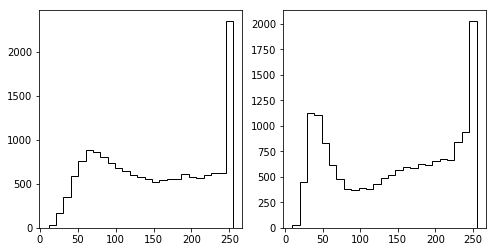

In [21]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(121)
ax.hist(rgb2gray(H_channel_v['tumor']).ravel(), bins=25, histtype='step', color='black')

ax = plt.subplot(122)
ax.hist(rgb2gray(H_channel_v['normal']).ravel(), bins=25, histtype='step', color='black')


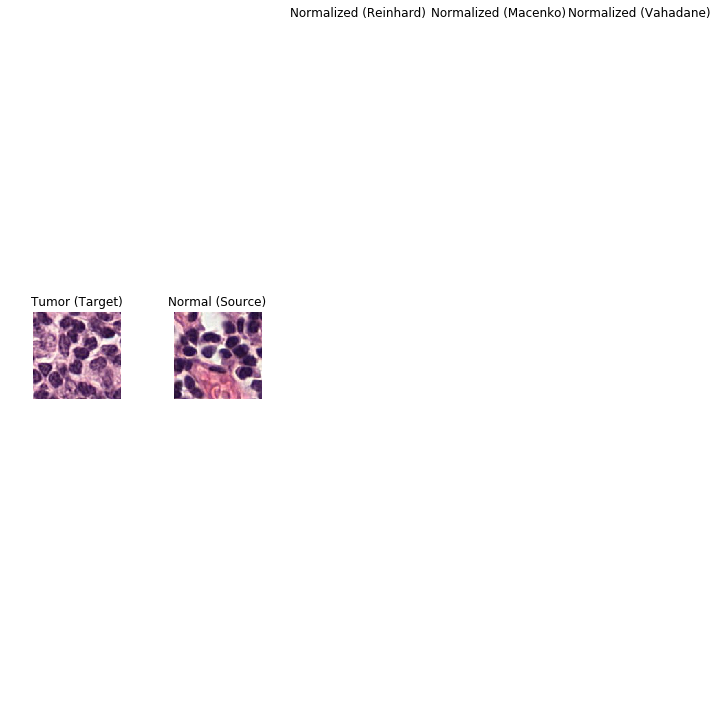

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(151)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor (Target)')

ax = plt.subplot(152)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal (Source)')

ax = plt.subplot(153)
ax.set_axis_off()
#ax.imshow(normalized_rgb_r)
ax.set_title('Normalized (Reinhard)')



ax = plt.subplot(154)
ax.set_axis_off()
#ax.imshow(normalized_rgb_m[0])
ax.set_title('Normalized (Macenko)')

ax = plt.subplot(155)
ax.set_axis_off()
#ax.imshow(normalized_rgb_v[0])
ax.set_title('Normalized (Vahadane)')

fig.tight_layout()

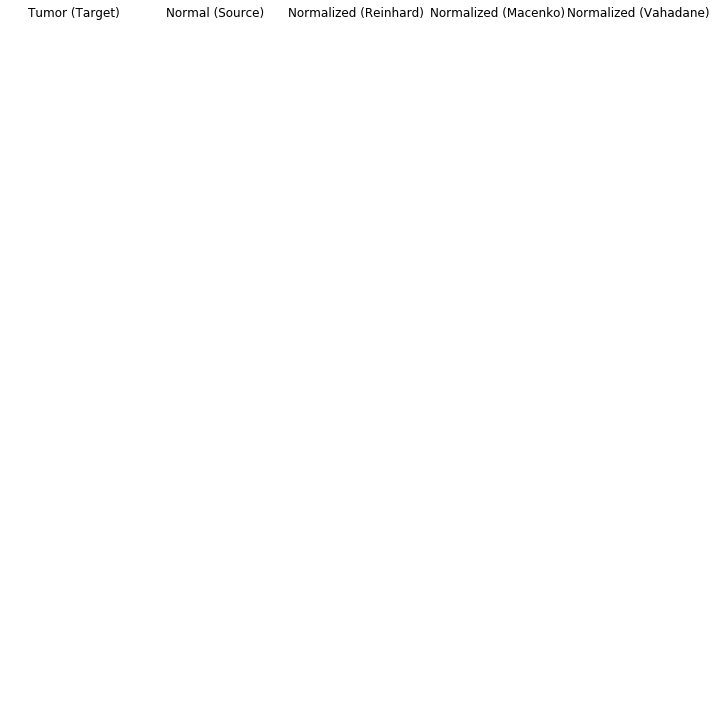

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(151)
ax.set_axis_off()
#ax.imshow(np.asarray(normalize_brightness(np.asarray(tumor_rgb, dtype=np.uint8), 99), dtype=np.float32))
#ax.imshow(normalize_brightness(tumor_rgb,  95))
ax.set_title('Tumor (Target)')

ax = plt.subplot(152)
ax.set_axis_off()
#ax.imshow(normal_rgb)
#ax.imshow(normalize_brightness(normal_rgb,  95))
ax.set_title('Normal (Source)')

ax = plt.subplot(153)
ax.set_axis_off()
#ax.imshow(normalized_rgb_r)
ax.set_title('Normalized (Reinhard)')


ax = plt.subplot(154)
ax.set_axis_off()
#ax.imshow(normalize_brightness(normalized_rgb_m[0], 99))
ax.set_title('Normalized (Macenko)')

ax = plt.subplot(155)
ax.set_axis_off()
#ax.imshow(normalized_rgb_v[0])
ax.set_title('Normalized (Vahadane)')

fig.tight_layout()

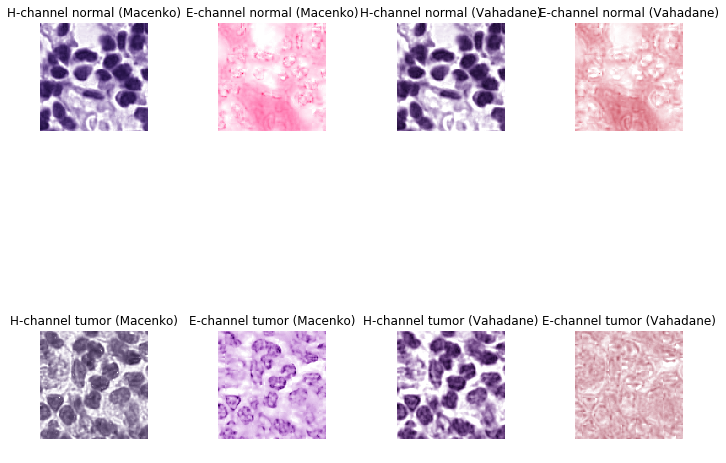

In [24]:
keys = ['normal', 'tumor']
fig = plt.figure(figsize=(10, 10))
index = 1
for key in keys:
    ax = plt.subplot(2,4,index)
    ax.set_axis_off()
    ax.imshow(H_channel_m[key]/255)
    ax.set_title('H-channel {} (Macenko)'.format(key))
    
    ax = plt.subplot(2,4,index+1)
    ax.set_axis_off()
    ax.imshow(E_channel_m[key]/255)
    ax.set_title('E-channel {} (Macenko)'.format(key))

    
    ax = plt.subplot(2,4,index+2)
    ax.set_axis_off()
    ax.imshow(H_channel_v[key]/255)
    ax.set_title('H-channel {} (Vahadane)'.format(key))

    ax = plt.subplot(2,4,index+3)
    ax.set_axis_off()
    ax.imshow(E_channel_v[key]/255)
    ax.set_title('E-channel {} (Vahadane)'.format(key))
    index += 4

fig.tight_layout()

In [25]:
xu_fit = {}
H_channel_x = {}
E_channel_x = {}

xu_fit['tumor'] = XuNormalization()#(lambda1=0.1, lambda2=0.0, gamma1=0.0)
xu_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

xu_fit['normal'] = XuNormalization()#(lambda1=0.1, lambda2=0.0, gamma1=0.0)
xu_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))


H_channel_x['tumor'] = xu_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_x['tumor'] = xu_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_x['normal'] = xu_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_x['normal'] = xu_fit['normal'].get_eosin_channel(normal_rgb)


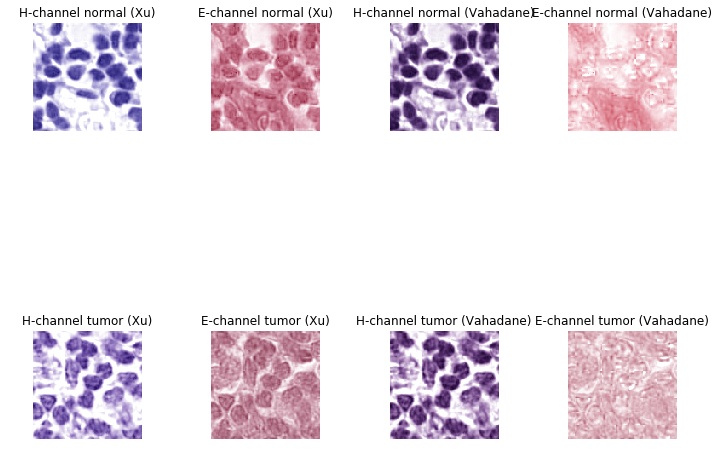

In [26]:
keys = ['normal', 'tumor']
fig = plt.figure(figsize=(10, 10))
index = 1
for key in keys:
    ax = plt.subplot(2,4,index)
    ax.set_axis_off()
    ax.imshow(H_channel_x[key]/255)
    ax.set_title('H-channel {} (Xu)'.format(key))
    
    ax = plt.subplot(2,4,index+1)
    ax.set_axis_off()
    ax.imshow(E_channel_x[key]/255)
    ax.set_title('E-channel {} (Xu)'.format(key))

    
    ax = plt.subplot(2,4,index+2)
    ax.set_axis_off()
    ax.imshow(H_channel_v[key]/255)
    ax.set_title('H-channel {} (Vahadane)'.format(key))

    ax = plt.subplot(2,4,index+3)
    ax.set_axis_off()
    ax.imshow(E_channel_v[key]/255)
    ax.set_title('E-channel {} (Vahadane)'.format(key))
    index += 4

fig.tight_layout()

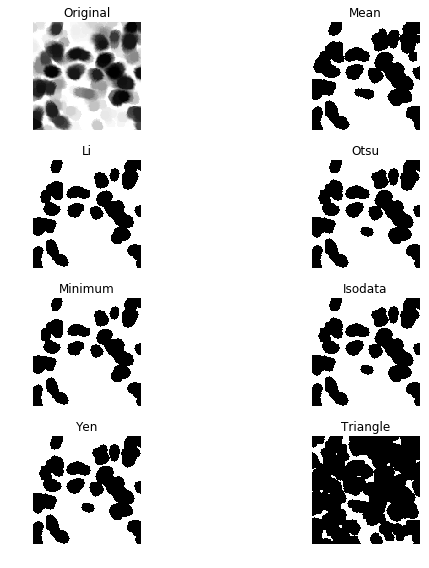

In [27]:
fig, ax = try_all_threshold(imclosing(rgb2gray(H_channel_v['normal']), 5),
                            figsize=(10, 8), verbose=False)


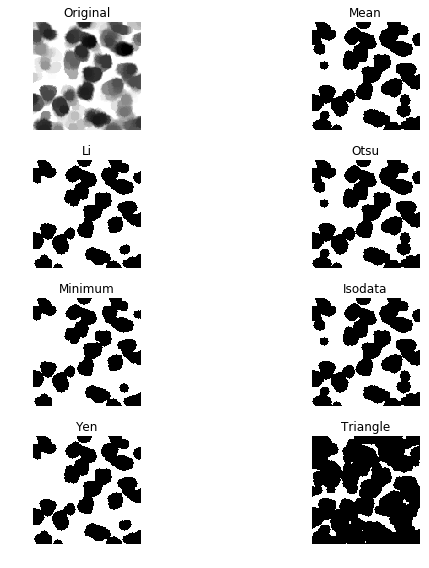

In [28]:
fig, ax = try_all_threshold(imclosing(rgb2gray(H_channel_v['tumor']), 5),
                            figsize=(10, 8), verbose=False)


In [29]:
import numpy as np
import scipy.ndimage.measurements as ms


def condense(im_label):
    """
    Shifts labels in a label image to fill in gaps corresponding to missing
    values.
    Parameters
    ----------
    im_label : array_like
        A label image generated by segmentation methods.
    Returns
    -------
    Condensed : array_like
        A label image where all values > 0 are shifted down to fill gaps.
    See Also
    --------
    histomicstk.segmentation.label.shuffle
    """

    # initialize output
    Condensed = im_label.copy()

    # get extent of each object
    Locations = ms.find_objects(Condensed)

    # initialize counter
    Counter = 1

    # fill in new values
    for i in np.arange(1, len(Locations)+1):
        if Locations[i-1] is not None:
            Patch = Condensed[Locations[i-1]]
            Patch[Patch == i] = Counter
            Counter += 1

    return Condensed

In [30]:
import numpy as np
import scipy.ndimage.measurements as ms



def area_open(im_label, min_area):
    """Removes small objects from label image.
    Parameters
    ----------
    im_label : array_like
        A uint32 type label image generated by segmentation methods.
    min_area : int
        minimum area threshold for objects. Objects with fewer than 'min_area'
        pixels will be zeroed to merge with background.
    Returns
    -------
    im_open : array_like
        A uint32 label where objects with pixels < min_area are removed.
    Notes
    -----
    Objects are assumed to have positive nonzero values. im_label image will be
    condensed during processing.
    See Also
    --------
    histomicstk.segmentation.label.condense,
    histomicstk.segmentation.label.shuffle,
    histomicstk.segmentation.label.split,
    histomicstk.segmentation.label.width_open
    """

    # copy input image
    im_open = im_label.copy()

    # condense label image
    if np.unique(im_open).size-1 != im_open.max():
        im_open = condense(im_open)

    # count pixels in each object
    Counts, Edges = np.histogram(im_open, bins=im_open.max()+1)

    # get locations of objects in initial image
    Locations = ms.find_objects(im_open)

    # iterate through objects, zeroing where needed
    for i in np.arange(1, Counts.size):
        if Counts[i] < min_area:

            # extract object from label image
            Template = im_open[Locations[i-1]]

            # label mask of object 'i'
            Template[Template == i] = 0

    # condense to fill gaps
    im_open = condense(im_open)

    return im_open

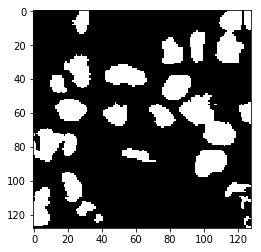

In [31]:
im_nuclei_stain = rgb2gray(H_channel_v['normal'])
foreground_threshold = 60
im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

plt.imshow(im_fgnd_mask, cmap='gray')

In [32]:
threshold_otsu(im_nuclei_stain)

139.26202352462784

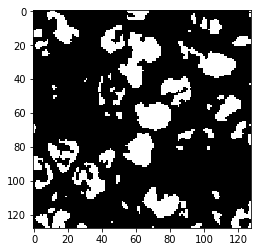

In [33]:
im_nuclei_stain = rgb2gray(H_channel_v['tumor'])

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < threshold_otsu(im_nuclei_stain)/2)

plt.imshow(im_fgnd_mask, cmap='gray')

In [34]:
from matplotlib.colors import LogNorm
from sklearn import mixture

clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(rgb2gray(H_channel_v['normal']).flatten().reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [35]:
clf.means_

array([[239.66577571],
       [155.45096008],
       [ 46.33947733]])

In [36]:
rgb2gray(H_channel_v['tumor']).flatten()

array([173.71850692, 188.20476607, 194.8353104 , ...,  85.18851353,
        69.51876848,  55.3015535 ])

In [37]:
im_nuclei_stain = rgb2gray(H_channel_v['normal'])

threshold_otsu(im_nuclei_stain)/2

69.63101176231392

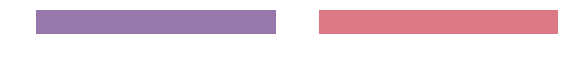

In [39]:
vahadane_fit['normal'].get_both_stains()

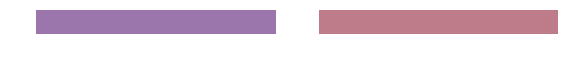

In [40]:
vahadane_fit['tumor'].get_both_stains()

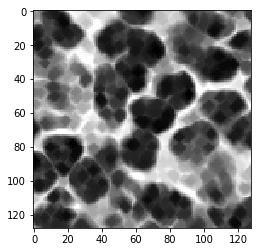

In [41]:
eroded = imerode(rgb2gray(H_channel_v['tumor']), 2)
plt.imshow(eroded, cmap='gray')

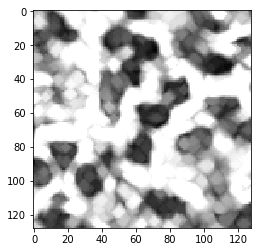

In [42]:
dilated = imdilate(rgb2gray(H_channel_v['tumor']), 2)
plt.imshow(dilated, cmap='gray')

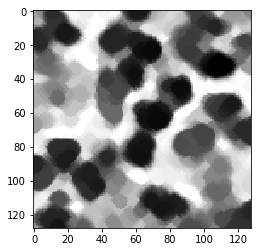

In [43]:
oc = open_close(rgb2gray(H_channel_v['tumor']), 2, 4)
plt.imshow(oc, cmap='gray')

In [44]:
 threshold_otsu(oc)

155.77398175264935

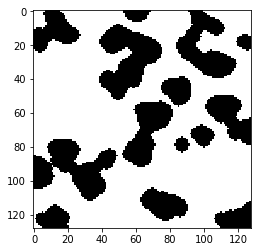

In [45]:

plt.imshow(oc > 0.7*threshold_otsu(oc), cmap='gray')

# Extreme example

In [46]:
i3 = read_as_rgb('../data/images/i3.png')

In [47]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(i3).astype(np.uint8))
H_channel = macenko_fit.get_hematoxylin_channel(i3)


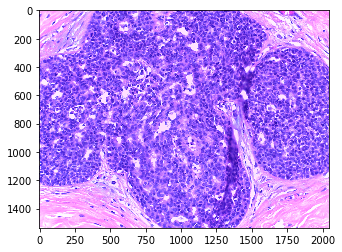

In [48]:
plt.imshow(i3)

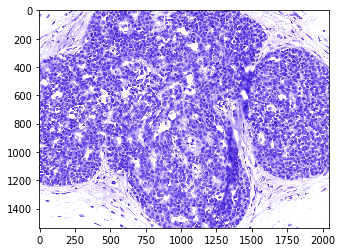

In [49]:
plt.imshow(H_channel/255, cmap='gray')

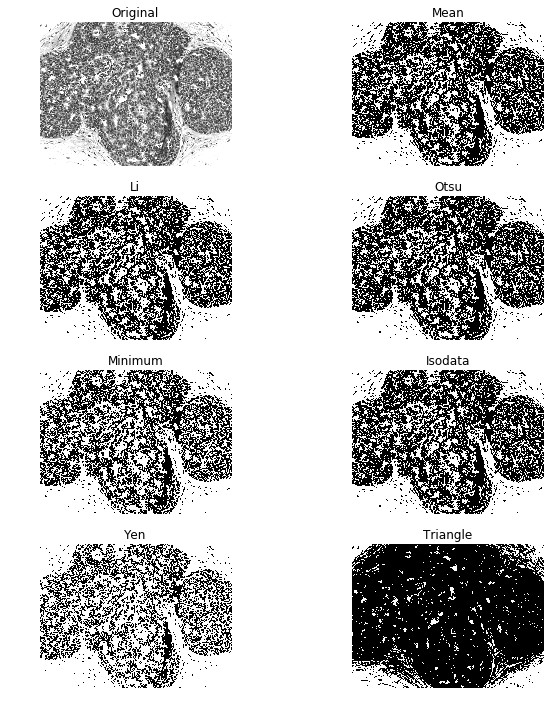

In [50]:
fig, ax = try_all_threshold(rgb2gray(H_channel), figsize=(10,10), verbose=False)

In [51]:
v = read_as_rgb('../data/images/vahadane_ex.png')

In [52]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(v).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(v).astype(np.uint8))

In [53]:
vahadane_fit = VahadaneNormalization()
vahadane_fit.fit(np.asarray(v).astype(np.uint8))
normalized_rgb_v = vahadane_fit.transform(np.asarray(v).astype(np.uint8))

In [54]:
H_channel = macenko_fit.get_hematoxylin_channel(v)
E_channel = macenko_fit.get_eosin_channel(v)

H_channel_v = vahadane_fit.get_hematoxylin_channel(v)
E_channel_v = vahadane_fit.get_eosin_channel(v)

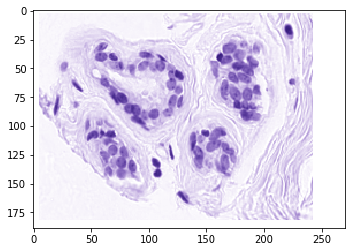

In [55]:
plt.imshow(H_channel/255)

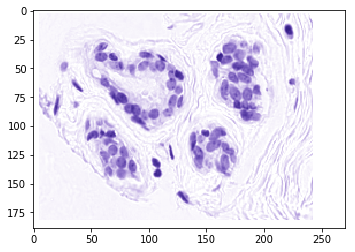

In [56]:
plt.imshow(H_channel_v/255)

array([237.68869626, 101.79623832, 172.71585898])

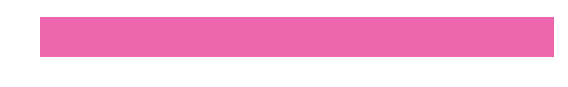

In [57]:
macenko_fit.get_eosin_stain()

array([145.37191281, 116.43554673, 195.84945819])

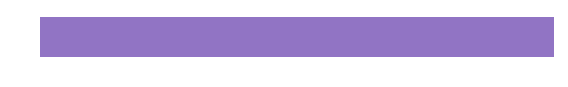

In [58]:
macenko_fit.get_hematoxylin_stain()

In [59]:
H_channel = macenko_fit.get_hematoxylin_channel(v, total=False)
E_channel = macenko_fit.get_eosin_channel(v, total=False)

H_channel_v = vahadane_fit.get_hematoxylin_channel(v, total=False)
E_channel_v = vahadane_fit.get_eosin_channel(v, total=False)

In [60]:
fg, bg, t= poisson_deconvolve(H_channel_v.astype(np.uint8))

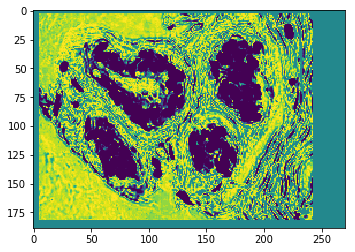

In [61]:
plt.imshow(fg)

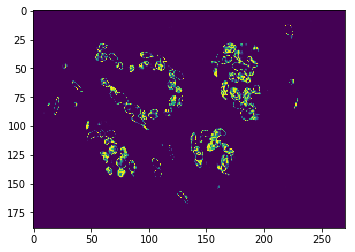

In [62]:
plt.imshow(bg*255)

In [63]:
cut = perform_binary_cut(fg, bg)

(189, 271, 2) (2, 2)


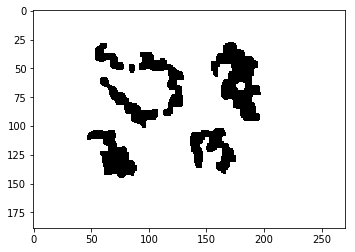

In [64]:
plt.imshow(cut, cmap='gray')

# Dynamic Segmentation

[[7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 ...
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]]
pixels: (array([  0,   0,   0, ..., 127, 127, 127]), array([  0,   1,   2, ..., 125, 126, 127]))
pixels: (array([ 58,  58,  58,  59,  59,  60,  61,  73, 121]), array([ 91,  92,  93,  92,  93,  93,  94, 105,   5]))
pixels: (array([], dtype=int64), array([], dtype=int64))
pixels: (array([], dtype=int64), array([], dtype=int64))
pixels: (array([], dtype=int64), array([], dtype=int64))
Number of nuclei =  16


/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(0.0, 128.0, 0.0, 128.0)

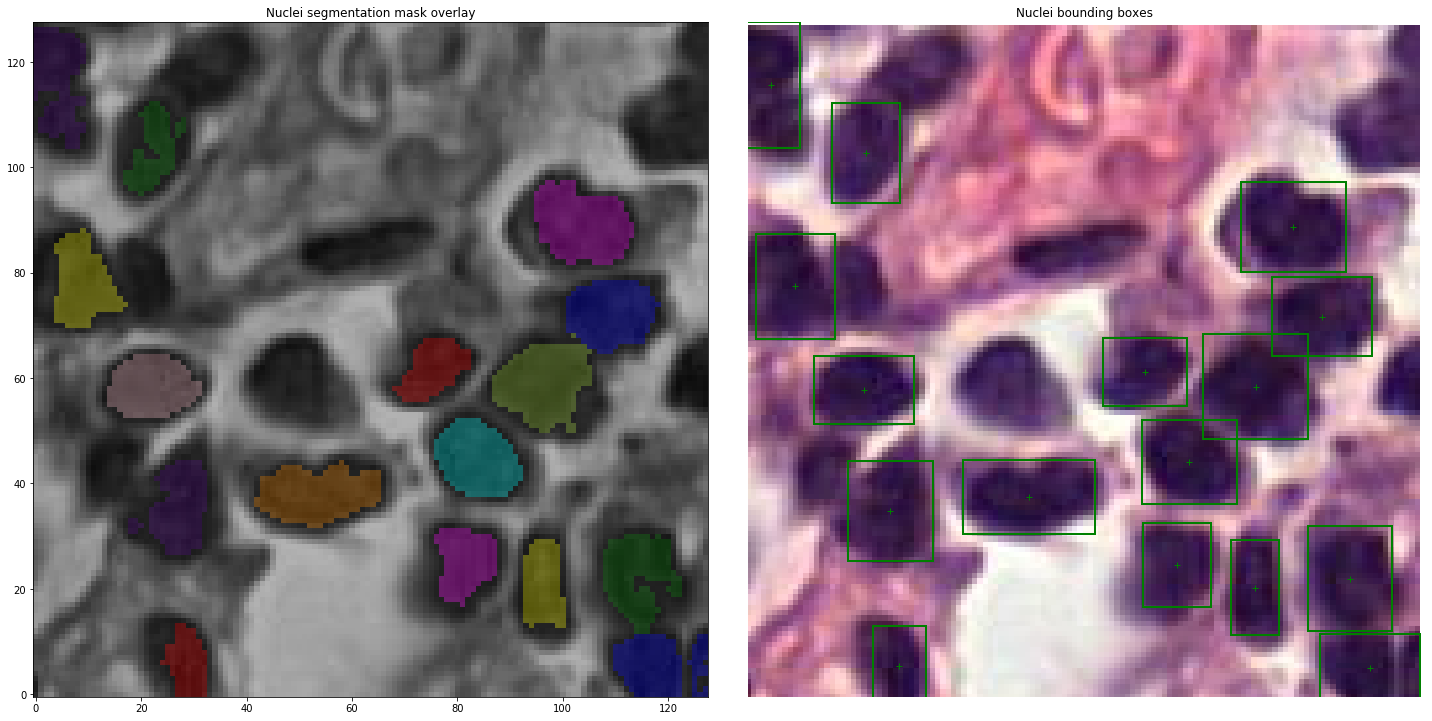

In [146]:
#im_nuclei_stain = rgb2gray(H_channel_v['tumor'])
#im_input = tumor_rgb
import numpy as np
import skimage.measure

from _max_clustering_cython import _max_clustering_cython


def max_clustering(im_response, im_fgnd_mask, r=10):
    """Local max clustering pixel aggregation for nuclear segmentation.
    Takes as input a constrained log or other filtered nuclear image, a binary
    nuclear mask, and a clustering radius. For each pixel in the nuclear mask,
    the local max is identified. A hierarchy of local maxima is defined, and
    the root nodes used to define the label image.
    Parameters
    ----------
    im_response : array_like
        A filtered-smoothed image where the maxima correspond to nuclear
        center. Typically obtained by constrained-LoG filtering on a
        hematoxylin intensity image obtained from ColorDeconvolution.
    im_fgnd_mask : array_like
        A binary mask of type boolean where nuclei pixels have value
        'True', and non-nuclear pixels have value 'False'.
    r : float
        A scalar defining the clustering radius. Default value = 10.
    Returns
    -------
    im_label : array_like
        im_label image where positive values correspond to foreground pixels that
        share mutual sinks.
    seeds : array_like
        An N x 2 array defining the (x,y) coordinates of nuclei seeds.
    max_response : array_like
        An N x 1 array containing the maximum response value corresponding to
        'seeds'.
    See Also
    --------
    histomicstk.filters.shape.clog
    References
    ----------
    .. [#] XW. Wu et al "The local maximum clustering method and its
       application in microarray gene expression data analysis,"
       EURASIP J. Appl. Signal Processing, volume 2004, no.1, pp.53-63,
       2004.
    .. [#] Y. Al-Kofahi et al "Improved Automatic Detection and Segmentation
       of Cell Nuclei in Histopathology Images" in IEEE Transactions on
       Biomedical Engineering,vol.57,no.4,pp.847-52, 2010.
    """

    # find local maxima of all foreground pixels
    mval, mind = _max_clustering_cython(
        im_response, im_fgnd_mask.astype(np.int32), r
    )

    # identify connected regions of local maxima and define their seeds
    im_label = skimage.measure.label(im_fgnd_mask & (im_response == mval))

    # compute normalized response
    min_resp = im_response.min()
    max_resp = im_response.max()
    resp_range = max_resp - min_resp

    im_response_nmzd = (im_response - min_resp) / resp_range

    # compute object properties
    obj_props = skimage.measure.regionprops(im_label, im_response_nmzd)

    obj_props = [prop for prop in obj_props if np.isfinite(prop.weighted_centroid).all()]

    num_labels = len(obj_props)

    # extract object seeds
    seeds = np.array(
        [obj_props[i].weighted_centroid for i in range(num_labels)])
    seeds = np.round(seeds).astype(np.int)

    # fix seeds outside the object region - happens for non-convex objects
    for i in range(num_labels):

        sy = seeds[i, 0]
        sx = seeds[i, 1]

        if im_label[sy, sx] == obj_props[i].label:
            continue

        # find object point with closest manhattan distance to center of mass
        pts = obj_props[i].coords

        ydist = np.abs(pts[:, 0] - sy)
        xdist = np.abs(pts[:, 1] - sx)

        seeds[i, :] = pts[np.argmin(xdist + ydist), :]

        assert im_label[seeds[i, 0], seeds[i, 1]] == obj_props[i].label

    # get seed responses
    max_response = im_response[seeds[:, 0], seeds[:, 1]]

    # set label of each foreground pixel to the label of its nearest peak
    im_label_flat = im_label.ravel()

    pind = np.flatnonzero(im_fgnd_mask)

    mind_flat = mind.ravel()

    im_label_flat[pind] = im_label_flat[mind_flat[pind]]

    # return
    return im_label, seeds, max_response

#im_nuclei_stain = rgb2gray(H_channel_v['normal'])
im_input = normal_rgb

clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(im_nuclei_stain.flatten().reshape(-1, 1))

# segment foreground
#foreground_threshold = threshold_otsu(im_nuclei_stain)/2
foreground_threshold = clf.means_.min()

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 5 
max_radius = 11

im_log_max, im_sigma_max = cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 3

im_nuclei_seg_mask, seeds, maxima = max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask =area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=12)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=12)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)
plt.tight_layout()
plt.axis('off')
#plt.savefig('tumor_segmented.png')


In [77]:
from pyvirchow.segmentation import poisson_deconvolve, perform_binary_cut, max_clustering
from pyvirchow.segmentation import collapse_labels, collapse_small_area, laplace_of_gaussian

In [72]:
#fg, bg, t= poisson_deconvolve(H_channel_v.astype(np.uint8))
fg, bg, t= poisson_deconvolve(im_nuclei_stain.astype(np.uint8))


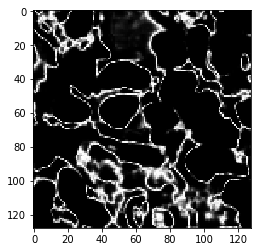

In [73]:
plt.imshow(fg, cmap='gray')

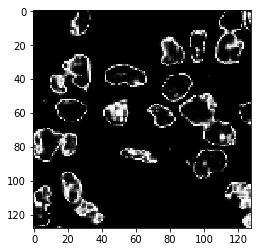

In [74]:
plt.imshow(bg, cmap='gray')

In [75]:
segmeneted = perform_binary_cut(background=fg, foreground=bg)

(128, 128, 2) (2, 2)


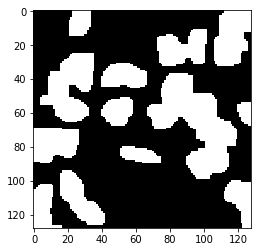

In [76]:
plt.imshow(segmeneted, cmap='gray')

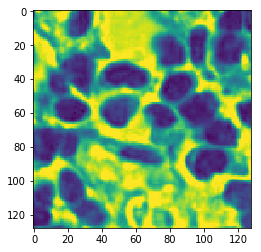

In [171]:
plt.imshow(im_nuclei_stain)

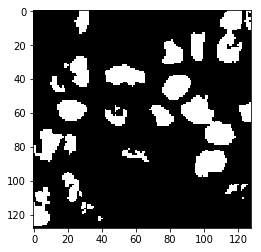

In [71]:
foreground_threshold = clf.means_.min()

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)
plt.imshow(im_fgnd_mask, cmap='gray')

In [132]:
def cdog(im_input, im_mask, sigma_min, sigma_max, num_octave_levels=3):
    """SCale-adaptive Multiscale Difference-of-Gaussian (DoG) filter for
    nuclei/blob detection.
    Computes the maximal DoG response over a series of scales where in the
    applicable scales at each pixel are constrained to be below an upper-bound
    equal to 2 times the distance to the nearest non-nuclear/background pixel.
    This function uses an approach similar to SIFT interest detection
    where in the scale space between the specified min and max sigma values is
    divided into octaves (scale/sigma is doubled after each octave) and each
    octave is divided into sub-levels. The gaussian images are downsampled by 2
    at the end of each octave to keep the size of convolutional filters small.
    Parameters
    ----------
    im_input : array_like
        A hematoxylin intensity image obtained from ColorDeconvolution. Objects
        are assumed to be dark with a light background.
    mask : array_like
        A binary image where nuclei pixels have non-zero values
    sigma_min : double
        Minumum sigma value for the scale space. For blob detection, set this
        equal to minimum-blob-radius / sqrt(2).
    sigma_max : double
        Maximum sigma value for the scale space. For blob detection, set this
        equal to maximum-blob-radius / sqrt(2).
    num_octave_levels : int
        Number of levels per octave in the scale space.
    Returns
    -------
    im_dog_max : array_like
        An intensity image containing the maximal DoG response accross
        all scales for each pixel
    im_sigma_max : array_like
        An intensity image containing the sigma value corresponding to the
        maximal LoG response at each pixel. The nuclei/blob radius for
        a given sigma value can be calculated as sigma * sqrt(2).
    References
    ----------
    .. [*] D.G. Lowe "Distinctive image features from scale-invariant
           keypoints." International journal of computer vision, vol. 60,
           no. 2, 91-110, 2004.
    """

    im_input = im_input.astype(np.float)

    # generate distance map
    im_dmap = distance_transform_edt(im_mask)

    # compute max sigma at each pixel as 2 times the distance to background
    im_sigma_ubound = 2.0 * im_dmap

    # clip max sigma values to specified range
    im_sigma_ubound = np.clip(im_sigma_ubound, sigma_min, sigma_max)

    # compute number of levels in the scale space
    sigma_ratio = 2 ** (1.0 / num_octave_levels)

    k = int(math.log(float(sigma_max) / sigma_min, sigma_ratio)) + 1

    # Compute maximal DoG filter response accross the scale space
    sigma_cur = sigma_min
    im_gauss_cur = gaussian_filter(im_input, sigma_cur)
    im_sigma_ubound_cur = im_sigma_ubound.copy()
    print(im_sigma_ubound_cur)
    MIN_FLOAT = np.finfo(im_input.dtype).min

    im_dog_max = np.zeros_like(im_input)
    im_dog_max[:, :] = MIN_FLOAT
    im_dog_octave_max = im_dog_max.copy()

    im_sigma_max = np.zeros_like(im_input)
    im_sigma_octave_max = np.zeros_like(im_input)

    n_level = 0
    n_octave = 0

    for i in range(k + 1):

        # calculate sigma at next level
        sigma_next = sigma_cur * sigma_ratio

        # Do cascaded convolution to keep convolutional kernel small
        # G(a) * G(b) = G(sqrt(a^2 + b^2))
        sigma_conv = np.sqrt(sigma_next ** 2 - sigma_cur ** 2)
        sigma_conv /= 2.0 ** n_octave
        im_gauss_next = gaussian_filter(im_gauss_cur, sigma_conv)

        # compute DoG
        im_dog_cur = im_gauss_next - im_gauss_cur
        #print(im_dog_cur)

        # constrain response
        im_dog_cur[im_sigma_ubound_cur < sigma_cur] = MIN_FLOAT
        #print('sigma_ubound: {}'.format(im_sigma_ubound_cur))
        #print('sigma_prev: {}'.format(sigma_cur))
        # update maxima
        max_update_pixels = np.where(im_dog_cur > im_dog_octave_max)
        print('pixels: {}'.format(max_update_pixels))
        if len(max_update_pixels[0]) > 0:

            im_dog_octave_max[max_update_pixels] = im_dog_cur[max_update_pixels]
            im_sigma_octave_max[max_update_pixels] = sigma_cur

            # print np.unique(im_sigma_octave_max)

        # update cur sigma
        sigma_cur = sigma_next
        im_gauss_cur = im_gauss_next

        # udpate level
        n_level += 1

        # Do additional processing at the end of each octave
        if i == k or n_level == num_octave_levels:

            # update maxima
            if num_octave_levels > 0:

                im_dog_octave_max_rszd = resize(
                    im_dog_octave_max, im_dog_max.shape, order=0)

            else:

                im_dog_octave_max_rszd = im_dog_octave_max

            max_pixels = np.where(
                im_dog_octave_max_rszd > im_dog_max)

            if len(max_pixels[0]) > 0:

                im_dog_max[max_pixels] = \
                    im_dog_octave_max_rszd[max_pixels]

                if num_octave_levels > 0:

                    im_sigma_octave_max_rszd = resize(
                        im_sigma_octave_max, im_dog_max.shape, order=0)

                else:

                    im_sigma_octave_max_rszd = im_sigma_octave_max

                im_sigma_max[max_pixels] = \
                    im_sigma_octave_max_rszd[max_pixels]

            # downsample images by 2 at the end of each octave
            if n_level == num_octave_levels:

                im_gauss_cur = im_gauss_next[::2, ::2]
                im_sigma_ubound_cur = im_sigma_ubound_cur[::2, ::2]

                im_dog_octave_max = im_dog_octave_max[::2, ::2]
                im_sigma_octave_max = im_sigma_octave_max[::2, ::2]

                n_level = 0
                n_octave += 1

    # set min vals to min response
    im_dog_max[im_dog_max == MIN_FLOAT] = 0

    return im_dog_max, im_sigma_max

In [133]:
#im_nuclei_stain = rgb2gray(H_channel_v['normal'])
im_input = normal_rgb

clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(im_nuclei_stain.flatten().reshape(-1, 1))

# segment foreground
#foreground_threshold = threshold_otsu(im_nuclei_stain)/2
foreground_threshold = clf.means_.min()

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 5 
max_radius = 11

im_log_max, im_sigma_max = cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)
im_log_max

[[7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 ...
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]
 [7.07106781 7.07106781 7.07106781 ... 7.07106781 7.07106781 7.07106781]]
pixels: (array([  0,   0,   0, ..., 127, 127, 127]), array([  0,   1,   2, ..., 125, 126, 127]))
pixels: (array([ 58,  58,  58,  59,  59,  60,  61,  73, 121]), array([ 91,  92,  93,  92,  93,  93,  94, 105,   5]))
pixels: (array([], dtype=int64), array([], dtype=int64))
pixels: (array([], dtype=int64), array([], dtype=int64))
pixels: (array([], dtype=int64), array([], dtype=int64))


/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


array([[ 4.24586843,  4.24586843,  3.43263673, ...,  7.90655442,
         7.00725073,  7.00725073],
       [ 4.24586843,  4.24586843,  3.43263673, ...,  7.90655442,
         7.00725073,  7.00725073],
       [ 4.17149661,  4.17149661,  3.38470484, ...,  7.4888559 ,
         6.56235015,  6.56235015],
       ...,
       [15.23557044, 15.23557044, 14.17802017, ...,  9.2107998 ,
        10.52877847, 10.99817586],
       [15.10734538, 15.10734538, 14.10884717, ...,  9.11492034,
        10.30742864, 10.92265205],
       [15.10734538, 15.10734538, 14.10884717, ...,  9.07057939,
        10.30742864, 10.8884132 ]])

/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [156]:
# detect and segment nuclei using local maximum clustering
local_max_search_radius = 3



In [157]:
im_nuclei_seg_mask

array([[ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       ...,
       [19, 19, 19, ..., 18, 18, 18],
       [19, 19, 19, ..., 18, 18, 18],
       [19, 19, 19, ..., 18, 18, 18]])

In [158]:
im_fgnd_mask 

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [167]:
segmeneted = perform_binary_cut(background=fg, foreground=bg)

(128, 128, 2) (2, 2)


In [160]:
im_fgnd_mask = segmeneted

Number of nuclei =  21


/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(0.0, 128.0, 0.0, 128.0)

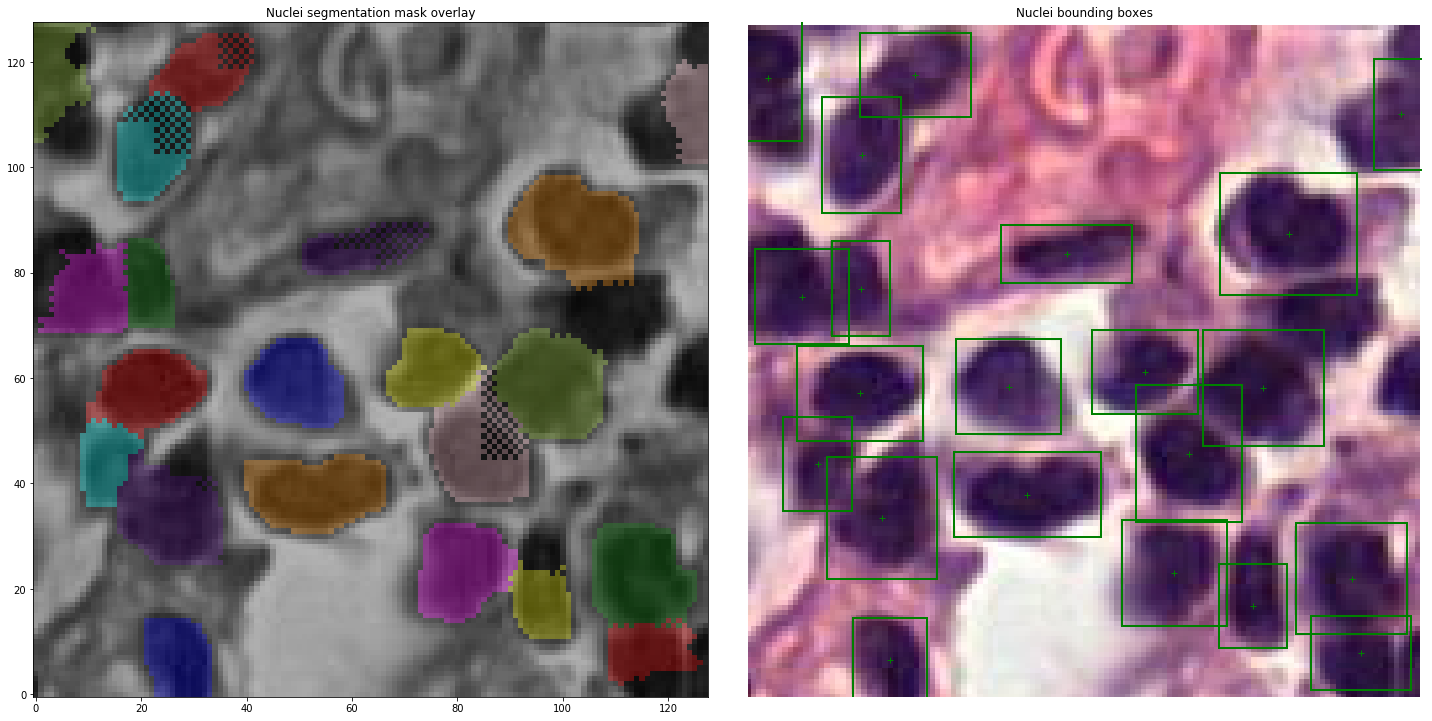

In [170]:
# filter out small objects
min_radius = 2
max_radius = 6 

im_log_max, im_sigma_max = laplace_of_gaussian(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

local_max_search_radius = 2
min_nucleus_area = 120
im_nuclei_seg_mask, seeds, maxima = max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)
im_nuclei_seg_mask = collapse_small_area(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=12)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=12)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)
plt.tight_layout()
plt.axis('off')
#plt.savefig('tumor_segmented.png')


In [164]:
im_nuclei_seg_mask, seeds, maxima = max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

/home/saket/anaconda3/lib/python3.5/site-packages/skimage/measure/_regionprops.py:299: RuntimeWarning: invalid value encountered in true_divide
  M[(0,) * self._ndim])
